using Revise

In [1]:
using TopOpt, LinearAlgebra, StatsFuns
using StatsFuns: logsumexp

E = 1.0 # Young’s modulus
v = 0.3 # Poisson’s ratio
f = 1.0 # downward force
rmin = 3.0

3.0

### Define the problem

In [2]:
problem = PointLoadCantilever(Val{:Linear}, (160, 40), (1.0, 1.0), E, v, f)

### Parameter settings

In [3]:
V = 0.5 # volume fraction
xmin = 0.0001 # minimum density
steps = 40 # maximum number of penalty steps, delta_p0 = 0.1

40

### Continuation SIMP

In [4]:
x0 = fill(0.5, 160 * 40) # initial design
N = length(x0)
penalty = TopOpt.PowerPenalty(1.0)
solver = FEASolver(Direct, problem; xmin=xmin, penalty=penalty)
stress = TopOpt.von_mises_stress_function(solver)
filter = DensityFilter(solver; rmin=rmin)
volfrac = TopOpt.Volume(solver)

obj = x -> volfrac(filter(PseudoDensities(x))) - V
thr = 150 # stress threshold
constr = x -> begin
    s = stress(filter(PseudoDensities(x)))
    return (s .- thr) / length(s)
end
alg = PercivalAlg()
options = PercivalOptions()
model = Model(obj)
addvar!(model, zeros(N), ones(N))
add_ineq_constraint!(model, constr)

x = copy(x0)
for p in [1.0, 2.0, 3.0]
    TopOpt.setpenalty!(solver, p)
    global r = optimize(model, alg, x; options)
    global x = r.minimizer
end

maximum(stress(filter(PseudoDensities(x0))))
maximum(stress(filter(PseudoDensities(x))))

[ Info:   iter        fx    normgp    normcx         μ     normy    sumc     inner_status        iter_type  
[ Info:      0  -3.3e-16   8.0e+01   1.9e+00   1.0e+01   8.0e+01       5
[ Info:      1   3.6e-15   8.0e+01   1.9e+00   1.0e+02   8.0e+01       9      first_order         update_μ
[ Info:      2  -6.6e-06   8.0e+01   8.0e-01   1.0e+03   8.0e+01      22      first_order         update_μ
[ Info:      3  -4.9e-01   7.0e-01   8.0e-02   1.0e+03   7.2e-01     589         max_eval         update_y
[ Info:      4  -4.9e-01   7.0e-01   8.0e-02   1.0e+04   7.2e-01     593         max_eval         update_μ
[ Info:      5  -4.9e-01   7.9e+01   8.0e-02   1.0e+04   8.0e+02     597         max_eval         update_y
[ Info:      6  -4.9e-01   7.9e+01   8.0e-02   1.0e+05   8.0e+02     601         max_eval         update_μ
[ Info:      7  -4.9e-01   7.9e+01   8.0e-02   1.0e+05   8.8e+03     605         max_eval         update_y
[ Info:      8  -4.9e-01   7.9e+01   8.0e-02   1.0e+06   8.8e+03     

151.7884771703217

### (Optional) Visualize the result using Makie.jl
Need to run `using Pkg; Pkg.add("Makie")` first and either `Pkg.add("CairoMakie")` or `Pkg.add("GLMakie")`

In [5]:
using Makie
using CairoMakie

alternatively, `using GLMakie`

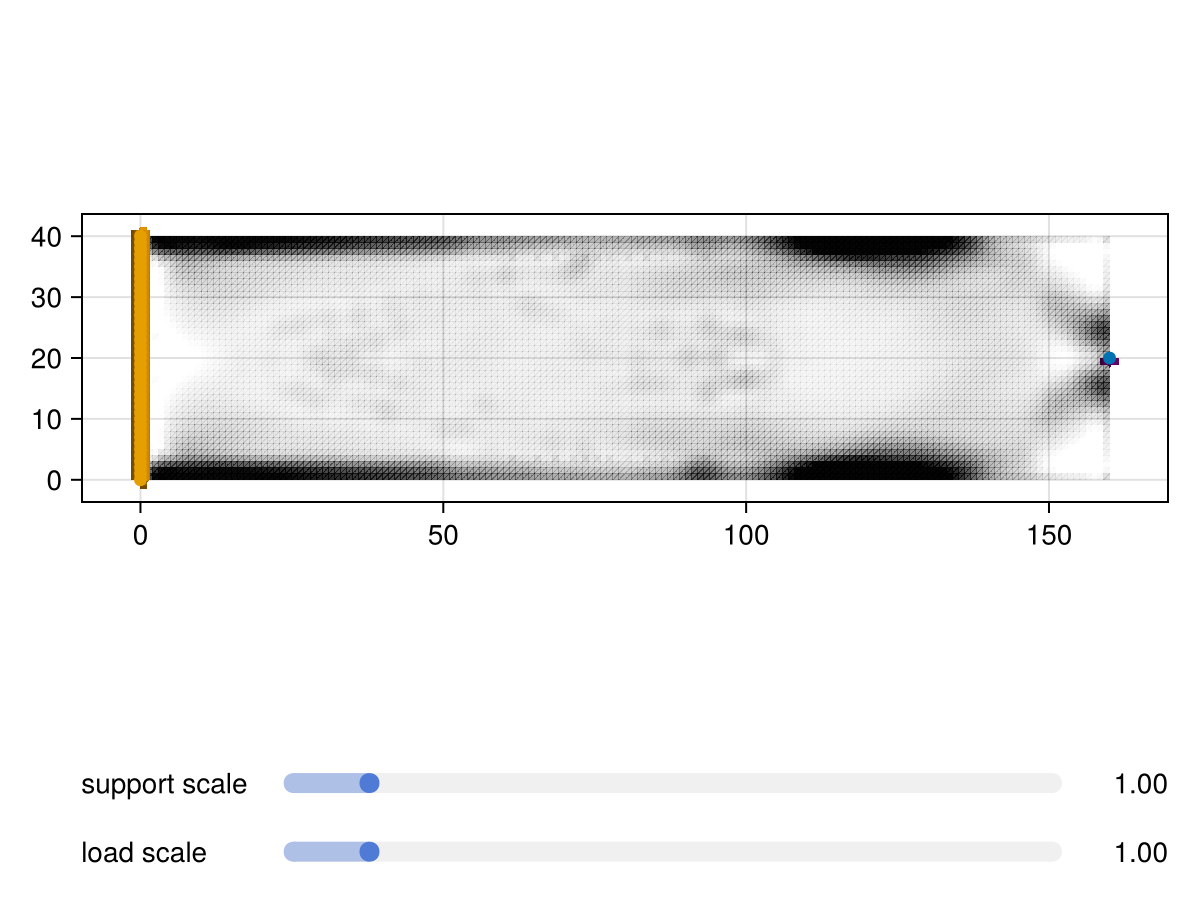

CairoMakie.Screen{IMAGE}


In [6]:
fig = visualize(
    problem;
    topology=r.minimizer,
    default_exagg_scale=0.07,
    scale_range=10.0,
    vector_linewidth=3,
    vector_arrowsize=0.5,
)
Makie.display(fig)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*